In [1]:
import pandas as pd
import json

In [2]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

## Read Data

In [182]:
# main data
csv_file = 'data/EXPORT_09042017173622.csv'

# json files to translate gestures, parcours into long text
#gestures_file = 'data/gestures.json' # this is the file edited manually by us to conform to json
gestures_file = 'data/gestures.json.orig' # this is the file edited manually by us to conform to json
parcours_file = 'data/parcours.json'
mutations_file = 'data/mutations.json'

files = (gestures_file, parcours_file, mutations_file)
dataframes = []

# NOTE THAT THESE JSON FILES ARE NOT JSON CONFORM
# each line is a json string on its own, so we need to process the json line by line and combine THEN into a list

In [183]:
def get_oid(oid_dict):
    # get from the original representation {u'$oid': u'589c8ed31337b5ab1e1be121'} just the oid
    return oid_dict['$oid']

In [184]:
for filename in files:
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]   # .decode("utf-8")

    lines = [json.loads(line) for line in lines]
    
    # convert list of json lines into Dataframe
    df = pd.DataFrame.from_dict(lines)
    # convert long $oid to short
    df['_id'] = df['_id'].apply(get_oid)
    
    # set the real id
    df.set_index('id', inplace=True)
    
    dataframes.append(df)

In [185]:
(gestures, parcours, mutations) = tuple(dataframes)

In [186]:
gestures

,_id,isGarbage,isNesture,name,slug
id,,,,,
G01,58a23a22d826756404709446,NaN,NaN,Single Rotation klein rechtsrum,rssr
G02,58a23a22d826756404709447,NaN,NaN,Single Rotation klein linksrum,rssl
G03,58a23a22d826756404709448,NaN,NaN,Oszillierende Rotation klein rechtsrum,rosr
G04,58a23a22d826756404709449,NaN,NaN,Oszillierende Rotation klein linksrum,rosl
G05,58a23a22d82675640470944a,NaN,NaN,Single Rotation groß rechtsrum,rsbr
G06,58a23a22d82675640470944b,NaN,NaN,Single Rotation groß linksrum,rsbl
G07,58a23a22d82675640470944c,NaN,NaN,Oszillierende Rotation groß rechtsrum,robr
G08,58a23a22d82675640470944d,NaN,NaN,Oszillierende Rotation groß linksrum,robl
G09,58a23a22d82675640470944e,NaN,NaN,Kontinuierliche Rotation groß rechtsrum,rcbr


In [188]:
parcours

,_id,comment,exercises,pose
id,,,,
P101,589c897d1337b5ab1e1be118,Zwinge X locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P102,589c8ba71337b5ab1e1be11c,Zwinge X locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P103,589c8dbd1337b5ab1e1be11f,Zwinge X locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P104,589c8ed31337b5ab1e1be121,Zwinge X fest links- und rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P105,589c8fcc1337b5ab1e1be125,Zwinge X oszilierend linksdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P106,589c901a1337b5ab1e1be127,Zwinge X oszilierend rechtsdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P107,589c90e31337b5ab1e1be12c,Zwinge Y locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P108,589c911c1337b5ab1e1be12e,Zwinge Y locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P109,589c91961337b5ab1e1be132,Zwinge Y locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...


In [187]:
parcours.ix[0,'exercises']

[{u'mutation': {u'id': u'M151'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}}]

In [165]:
parcours_df.ix[0,'pose']

{u'start': u'Host 008 ist auf Werkbank fixiert, Griffachse X, untere Spannbacke fixiert (Xcm), Gewinde genau in Mitte. Subject steht frontal vor Werkbank, etwas links von Host, F\xfc\xdfe in Schulterbreite, Arme h\xe4ngen locker hinunter.'}

In [189]:
mutations

,_id,hands,params,slug
id,,,,
M101,58a24ffa5097dc5998d3c5d0,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabaaaba
M102,58a24ffa5097dc5998d3c5d1,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabababa
M103,58a24ffa5097dc5998d3c5d2,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbaaaba
M104,58a24ffa5097dc5998d3c5d3,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbababa
M105,58a24ffa5097dc5998d3c5d4,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaacbaabba
M106,58a24ffa5097dc5998d3c5d5,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaadbabbba
M107,58a24ffa5097dc5998d3c5d6,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabaaaba
M108,58a24ffa5097dc5998d3c5d7,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabababa
M109,58a24ffa5097dc5998d3c5d8,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaabbaaaba


In [195]:
mutations.ix['M101','hands']

{u'right': {u'gesture': {u'id': u'G01'},
  u'host': {u'id': u'H008',
   u'name': u'Schraubzwinge klein',
   u'spot': {u'id': u'A', u'name': u'Drehgriff'}},
  u'instruction': u'Zwinge X locker rechtsdrehen einzeln'}}

In [197]:
mutations.ix['M103','params']

[{u'label': u'K\xf6rperhaltung', u'slug': u'm0', u'value': u'stehend'},
 {u'label': u'Spot', u'slug': u'm1', u'value': u'Drehgriff'},
 {u'label': u'Position Spot', u'slug': u'm2', u'value': u'mittig vor Subject'},
 {u'label': u'Orientierung Spot', u'slug': u'm3', u'value': u'Griffachse X'},
 {u'label': u'ausf\xfchrende Hand', u'slug': u'm4', u'value': u'Rechte'},
 {u'label': u'Handhaltung', u'slug': u'm5', u'value': u'Faust'},
 {u'label': u'Widerstand', u'slug': u'm6', u'value': u'Anziehphase'},
 {u'label': u'Drehweise',
  u'slug': u'm7',
  u'value': u'ganze Hand mitbewegen, ganze Hand umgreifen'},
 {u'label': u'Drehwinkel', u'slug': u'm8', u'value': u'90\xb0'},
 {u'label': u'Drehrichtung',
  u'slug': u'm9',
  u'value': u'rechtsrum (schlie\xdfen)'},
 {u'label': u'Bewegungsablauf', u'slug': u'm10', u'value': u'einzeln'},
 {u'label': u'2. Hand', u'slug': u'm11', u'value': u'ruht woanders'}]

In [ ]:
mutations.ix['M101','hands']

### Define handy function shortcuts

In [190]:
def gesture_name(gesture_id):
    return gestures.loc[gesture_id,'name']

## Read Experiment Data

In [7]:
# Experiment Data
data = pd.read_csv(csv_file)
data.shape

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1435576, 26)

In [8]:
data.shape

(1435576, 26)

In [9]:
data.columns

Index([u'Trainset-ID', u'Experiment-ID', u'Subject-ID', u'Observer-ID',
       u'collectedByHand', u'Collector-ID', u'TimeStamp', u'RFID-ID',
       u'GRASP-A', u'GRASP-B', u'GRASP-C', u'AX', u'AY', u'AZ', u'EX', u'EY',
       u'EZ', u'USERINPUT', u'HANDINGLOVE', u' Parcours-ID', u'Parcours-Step',
       u'Mutation-ID', u' Mutation/HandIsActive', u'Host-ID', u'Host/Spot-ID',
       u'Gesture-ID'],
      dtype='object')

In [10]:
data.head()

,Trainset-ID,Experiment-ID,Subject-ID,Observer-ID,collectedByHand,Collector-ID,TimeStamp,RFID-ID,GRASP-A,GRASP-B,...,EZ,USERINPUT,HANDINGLOVE,Parcours-ID,Parcours-Step,Mutation-ID,Mutation/HandIsActive,Host-ID,Host/Spot-ID,Gesture-ID
0,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,0,000000000000,781,8,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
1,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,19896,000000000000,212,213,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
2,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,29001,000000000000,782,0,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
3,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,29823,000000000000,179,185,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
4,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,46136,000000000000,782,6,...,-81.8750,False,True,P101,1,M151,True,H008,NaN,G15


## Some Data Stats

In [11]:
# how many subjects
data['Subject-ID'].unique().tolist()

['Andreas', 'Alfred', 'Claudia', 'Dominik']

In [12]:
# how many observers
data['Observer-ID'].unique().tolist()

['Clemens']

In [13]:
# how many hands
data['Collector-ID'].unique().tolist()

['R01', 'L01']

In [14]:
# how many RFID ids
data['RFID-ID'].unique().tolist()

['000000000000',
 '09006734114B',
 0,
 '05003DD5CD20',
 '760057911BAB',
 '13005E4BB7B1',
 '1400135B8AD6',
 '14001486BE38',
 '7600577D0D51',
 '140014CD1AD7',
 '280015E55981',
 '05008C2F993F']

In [15]:
# how many experiments
data['Experiment-ID'].unique().tolist()

['E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'E007', 'E008']

In [16]:
# how many training sets
len(data['Trainset-ID'].unique().tolist())

539

In [17]:
# how many parcours
len(data[' Parcours-ID'].unique())

116

In [18]:
data[' Parcours-ID'].unique()

array(['P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108',
       'P109', 'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116',
       'P117', 'P118', 'P401', 'P402', 'P403', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'P207', 'P208', 'P211', 'P212', 'P213',
       'P216', 'P217', 'P218', 'P221', 'P222', 'P223', 'P226', 'P227',
       'P228', 'P701', 'P702', 'P705', 'P706', 'P709', 'P710', 'P713',
       'P714', 'P801', 'P802', 'P601', 'P602', 'P603', 'P606', 'P607',
       'P608', 'P611', 'P612', 'P613', 'P616', 'P617', 'P618', 'P621',
       'P622', 'P623', 'P501', 'P502', 'P504', 'P503', 'P301', 'P302',
       'P306', 'P307', 'P308', 'P311', 'P312', 'P316', 'P317', 'P318',
       'P321', 'P322', 'P326', 'P327', 'P328', 'P119', 'P120', 'P121',
       'P231', 'P232', 'P234', 'P233', 'P236', 'P235', 'P717', 'P718',
       'P719', 'P720', 'P721', 'P722', 'P723', 'P724', 'P626', 'P627',
       'P628', 'P629', 'P630', 'P331', 'P332', 'P333', 'P334', 'P335',
      

In [19]:
# how many parcours steps
data['Parcours-Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [20]:
# how many mutations
len(data['Mutation-ID'].unique())

177

In [21]:
# how many gestures
len(data['Gesture-ID'].unique())

19

In [86]:
# which gestures exist
sorted(data['Gesture-ID'].unique())

['G01',
 'G02',
 'G03',
 'G04',
 'G05',
 'G06',
 'G07',
 'G08',
 'G09',
 'G10',
 'G11',
 'G12',
 'G13',
 'G14',
 'G15',
 'G16',
 'G17']

In [22]:
# how many hosts
len(data['Host-ID'].unique())

10

In [23]:
# which Host Spots
data['Host/Spot-ID'].unique().tolist()

[nan, 'A', 'B', 'F']

## Data Preprocessing

In [39]:
# rename some columns as the - in the column name does not allow for data.query()) to be used
# cut off the "-ID" suffix and replace - by _

for col in data.columns:
    if col.endswith('-ID'):
        data.rename(columns={col: col[:-3]}, inplace=True)
        print "Renamed", col, "->", col[:-3]
        col = col[:-3]
    if col.startswith(' '):
        data.rename(columns={col: col[1:]}, inplace=True)
        print "Renamed", col, "->", col[1:]
        col = col[1:]
    if '-' in col:
        new_col = col.replace('-','_')
        data.rename(columns={col: new_col}, inplace=True)
        print "Renamed", col, "->", new_col

Renamed  Parcours -> Parcours


/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [25]:
# remove rows that are not needed:
# all where Gesture-ID is NaN  (implies 'Mutation/HandIsActive' == False and Host is NaN)

data.dropna(axis=0, subset=['Gesture'], inplace=True)

In [27]:
# remove columns that we don't need
# to be ignored as communicated by MOM
cols_to_remove = ['Trainset','USERINPUT', 'HANDINGLOVE', 'Observer','Collector','RFID','Parcours_Step',
                  'Mutation/HandIsActive']

data.drop(cols_to_remove,inplace=True,axis=1)

In [28]:
data.shape

(780299, 18)

In [29]:
data

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15
10,E001,Andreas,right,116448,784,4,800,0.12,-0.06,-0.03,218.3125,9.2500,-81.7500,P101,M151,H008,NaN,G15
12,E001,Andreas,right,148753,783,0,798,0.21,-0.04,0.03,218.5000,9.3125,-81.7500,P101,M151,H008,NaN,G15
14,E001,Andreas,right,167422,784,2,798,0.18,-0.10,-0.08,218.6875,9.3750,-81.7500,P101,M151,H008,NaN,G15
16,E001,Andreas,right,187481,782,4,799,0.15,-0.18,-0.03,219.0000,9.4375,-81.7500,P101,M151,H008,NaN,G15
18,E001,Andreas,right,213733,784,13,799,0.15,-0.18,-0.17,219.1250,9.4375,-81.7500,P101,M151,H008,NaN,G15


In [30]:
# also in this evaluation, we use only one-hand devices and only people who are right-handers
data['collectedByHand'].unique().tolist()

['right', 'left']

In [31]:
sum(data['collectedByHand']=='right')

711360

In [32]:

sum(data['collectedByHand']=='left')

68939

In [33]:
# filter right hand, throw away left hand
data = data[data['collectedByHand']=='right']

## Look into the Data

In [40]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15


In [41]:
data.columns

Index([u'Experiment', u'Subject', u'collectedByHand', u'TimeStamp', u'GRASP_A',
       u'GRASP_B', u'GRASP_C', u'AX', u'AY', u'AZ', u'EX', u'EY', u'EZ',
       u'Parcours', u'Mutation', u'Host', u'Host/Spot', u'Gesture'],
      dtype='object')

### Get Experiment data: Filter for one experiment of one subject

In [110]:
def get_experiment(data,experiment,subject,parcours,gesture):
    query = []
    # by passing None, some parts of these can be omitted (returning more data)
    if experiment: query.append('Experiment==@exp')
    if subject: query.append('Subject==@subject')
    if parcours: query.append('Parcours==@parcours')
    if subject: query.append('Gesture==@gesture')
    # TODO filter by Parcours_Step, Mutation u/o Host
    
    query = " and ".join(query)
    print query
    return data.query(query)
    #return data.query('Experiment==@exp and Subject==@subject and Parcours==@parcours and Gesture==@gesture')



In [111]:
exp = 'E001'
subject = 'Andreas'
parcours = None #'P101'
gesture = 'G15'

mydata = get_experiment(data,exp,subject,parcours,gesture)
mydata.shape

Experiment==@exp and Subject==@subject and Gesture==@gesture


(11621, 18)

In [114]:
mydata['Mutation'].unique().tolist()

['M151', 'M452', 'M251', 'M257', 'M751', 'M752', 'M851', 'M651']

In [112]:
mydata

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15
10,E001,Andreas,right,116448,784,4,800,0.12,-0.06,-0.03,218.3125,9.2500,-81.7500,P101,M151,H008,NaN,G15
12,E001,Andreas,right,148753,783,0,798,0.21,-0.04,0.03,218.5000,9.3125,-81.7500,P101,M151,H008,NaN,G15
14,E001,Andreas,right,167422,784,2,798,0.18,-0.10,-0.08,218.6875,9.3750,-81.7500,P101,M151,H008,NaN,G15
16,E001,Andreas,right,187481,782,4,799,0.15,-0.18,-0.03,219.0000,9.4375,-81.7500,P101,M151,H008,NaN,G15
18,E001,Andreas,right,213733,784,13,799,0.15,-0.18,-0.17,219.1250,9.4375,-81.7500,P101,M151,H008,NaN,G15


### Check TimeStep deltas

In [87]:
# investigate time stamp mean and variance
mydata['TimeStamp'].diff().describe()

count      244.000000
mean     23688.918033
std      10407.436490
min       1580.000000
25%      16474.250000
50%      23934.500000
75%      28587.750000
max      70917.000000
Name: TimeStamp, dtype: float64

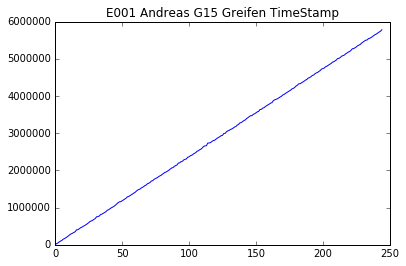

In [89]:
var = 'TimeStamp'
myplot(mydata,var)

#### TODO: Should we interpolate by event timestamps?


### Visualize timeline of sensor data of an experiment

In [63]:
params = ['AX', 'AY', 'AZ', 'EX', 'EY', 'EZ',]

In [46]:
var = 'EX'

In [44]:
def one_plot(mydata,var):
    y = mydata[var]
    x = range(len(y))
    #x = mydata['TimeStamp']
    plt.plot(x, y)
    title = "%s %s %s %s %s" % (exp,subject,gesture,gesture_name(gesture),var)
    plt.title(title)
    #plt.show()

In [100]:
def grid_plot(mydata):
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10)) #, sharex=True, sharey=True)
    title = "%s %s %s %s" % (exp,subject,gesture,gesture_name(gesture))
    fig.suptitle(title, fontsize=16)

    axes_list = axes.reshape(-1)

    for i, var in enumerate(params):

        # data
        y = mydata[var]
        x = range(len(y))
        #x = mydata['TimeStamp']

        # subplot index
        r = i % rows
        c = int(i / rows)
        axes[r,c].plot(x, y)
        axes[r,c].set_title(var)
    

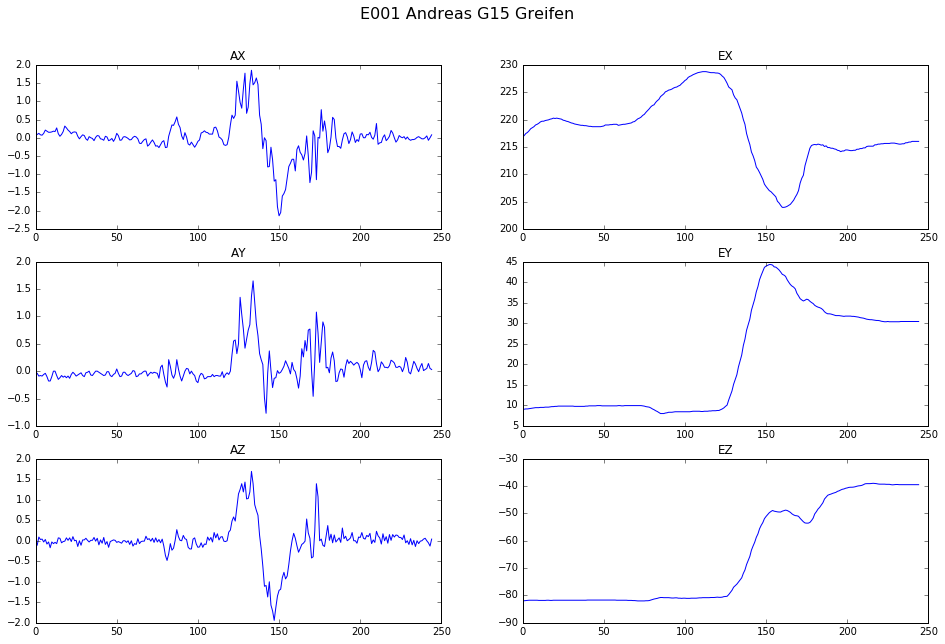

In [101]:
grid_plot(mydata)

['P101']

In [ ]:
# Standardize

In [ ]:
# Make groupings by Subject, Experiment, 

In [ ]:
# Calc derivatives

In [ ]:
# Time Normalize?

## Tasks

### 1) Recognize Host + Gesture

(maybe also Subject)

### 2) Recognize Gesture independent of host